In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import Voutput as vp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf
from scipy import linalg
import warnings
warnings.filterwarnings("ignore")

### 读取数据

In [2]:
exchange_df=pd.read_csv('../data/exchange_rate_data.csv').set_index('Collection')
exchange_df

,CNY/USD,EUR/USD,JPY/USD,GBP/USD
Collection,,,,
2002/1/1,0.120817,0.9031,0.007575,1.4451
2002/2/1,0.120817,0.8613,0.007476,1.4158
2002/3/1,0.120817,0.8652,0.007499,1.4190
2002/4/1,0.120817,0.8806,0.007501,1.4407
2002/5/1,0.120817,0.9062,0.007846,1.4621
...,...,...,...,...
2020/3/1,0.142412,1.1164,0.009258,1.2791
2020/4/1,0.141325,1.0934,0.009341,1.2394
2020/5/1,0.140704,1.0998,0.009367,1.2509


### 取滑动窗口

In [226]:
#取窗口
def window(df):
    window_df_list=list()
    for i in range(len(df)-35):
        window_df_list.append(df.iloc[i:i+36])
    return window_df_list
    
window_df_list=window(exchange_df)

### 单位根检验

In [227]:
#adf检验函数
def adf(df):
    p_list=[]
    t_list=[]
    currency_list=[]
    for currency in df.columns:
        currency_list.append(currency)
        test=list(adfuller(df.loc[:,currency]))
        t_list.append(test[0])
        p_list.append(test[1])
    return pd.DataFrame({'currency':currency_list,'t-test':t_list,'p-test':p_list})

### PCA

In [247]:
def PCA_component_1(df):
    pca=PCA(n_components=1)
    tran=pd.DataFrame(pca.fit_transform(df),columns={'pc_1'})
    components=pd.DataFrame(pca.components_,columns=df.columns,index={'pc_1'})
    explained_variance=pca.explained_variance_ratio_
    print(explained_variance)
    #return components
    return [tran,components]

In [251]:
test_df=window_df_list[110]
pc_1=PCA_component_1(test_df)[0]
c1=PCA_component_1(test_df)[1]
c1

[0.82982324]
[0.82982324]


,CNY/USD,EUR/USD,JPY/USD,GBP/USD
pc_1,-0.019801,0.870835,0.001355,0.491174


### VECM

In [161]:
def vecm_mod(df,exog_array):
    test1=df.reset_index(drop=True)
    vecm_mod=VECM(endog=test,exog=exog_array,deterministic='nc').fit(df)

In [166]:
adf(test_df)

,currency,t-test,p-test
0,CNY/USD,-1.376455,0.593510
1,EUR/USD,-1.881767,0.340686
2,JPY/USD,-0.268054,0.929909
3,GBP/USD,-2.760622,0.064122


In [173]:
test1=test_df.reset_index(drop=True)
vecm_mod=VECM(endog=test1,exog=pc_1,deterministic='nc',dates=test_df.index).fit()
vecm_mod2=VECM(endog=test1).fit()


#cdir(vecm_mod)
#vecm_mod.plot_data()
#adf(pd.DataFrame(vecm_mod.y_all.T))
#vecm_mod.summary()

In [191]:
#vecm_mod.summary()

In [193]:

irf = vecm_mod2.irf(15)
#irf_plots=irf.plot(orth=True)

0.8708353258911589

### VAR

In [267]:
def extract_impact(df,pca):
    for column in df.columns:
        df[column]=df[column].values-float(pca[column])
    return df

In [269]:
extract_df=extract_impact(test_df,c1)
extract_df

,CNY/USD,EUR/USD,JPY/USD,GBP/USD
Collection,,,,
2011/3/1,-2.827874,0.510465,0.010861,1.139726
2011/4/1,-2.827014,0.550665,0.010543,1.122026
2011/5/1,-2.826241,0.616165,0.010956,1.177826
2011/6/1,-2.825753,0.572265,0.011018,1.147926
2011/7/1,-2.825358,0.579965,0.011020,1.115826
2011/8/1,-2.824055,0.549365,0.011654,1.136626
2011/9/1,-2.823713,0.557465,0.011664,1.126726
2011/10/1,-2.823212,0.457265,0.011690,1.056226
2011/11/1,-2.822858,0.496765,0.011420,1.103426


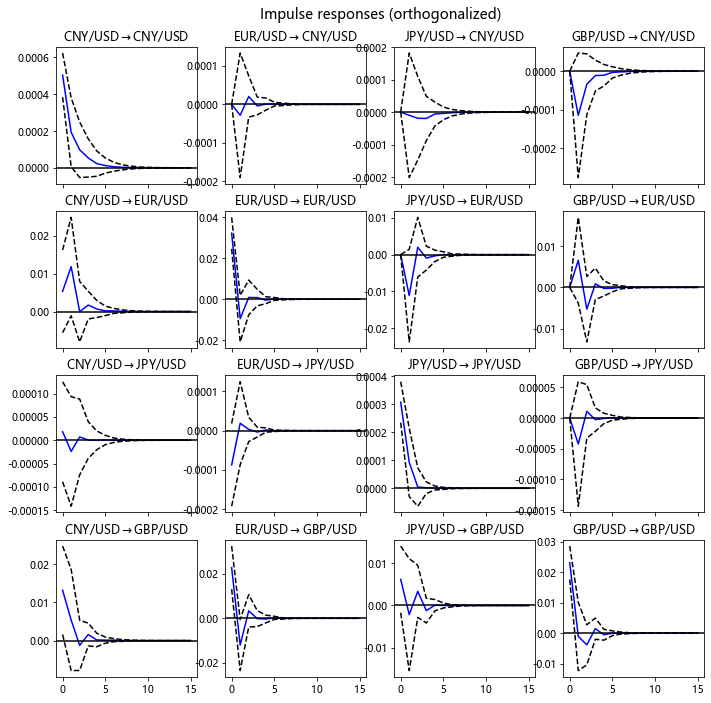

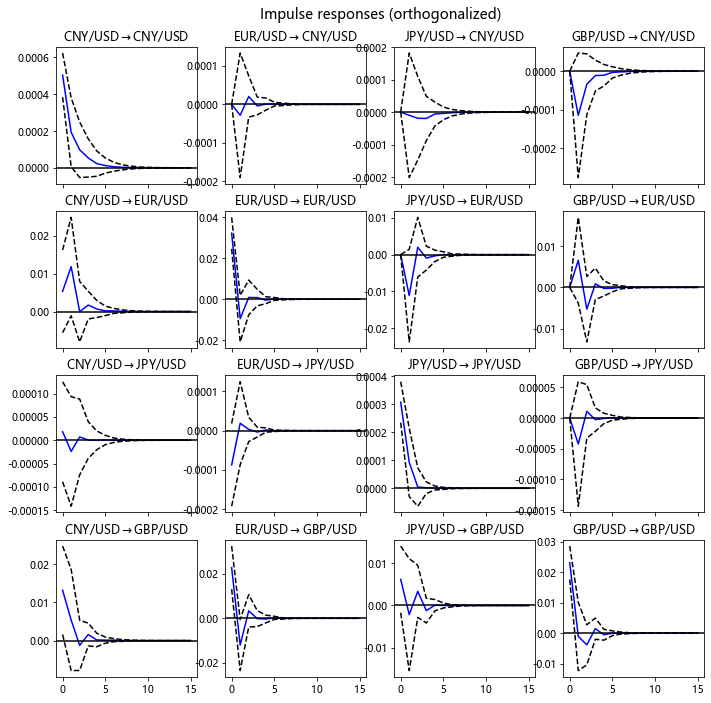

In [270]:
def var_model(df):
    diff1=df.diff(periods=1).dropna()
    var_mod=sm.tsa.VAR(diff1).fit(maxlags=1)
    return var_mod

var_mod=var_model(extract_df)
var_mod.irf(15).plot(orth=True)

### IRF结果转为Dataframe

In [140]:
# 目标对象为irf = var_mod.irf()，为以下数据类型：
# statsmodels.tsa.vector_ar.irf.IRAnalysis
class irf2df():  # 输出脉冲响应图数据
    def __init__(self, irf_obj):
        self.irf_obj = irf_obj
        self.get_names()
        self.irf_stderr()

    def irf_stderr(self):   #分别输出数据点和标准差
        self.irf_array=self.irf_obj.irfs
        datapoint=self.irf_array2df(self.irf_array)
        self.irf_datapoints=self.irf_df2csv(datapoint,'irf_datapoint')

        self.stderr_array=self.irf_obj.stderr()
        stderror = self.irf_array2df(self.stderr_array)
        self.irf_errorpoints=self.irf_df2csv(stderror, 'irf_stderror')

    def get_names(self):
        self.namelist=[]
        names=self.irf_obj.model.names  #变量名，查源码statsmodels/statsmodels/tsa/vector_ar/irf.py得到
        for i in names:
            temp1=str()
            temp1='->'+i
            for j in names:
                temp2=str()
                temp3=str()
                temp2=j
                temp3=temp2+temp1
                temp2=''
                self.namelist.append(temp3)

    def mergelist(self, array):  # 把多个array合并为一个list
        merged = []
        for i in range(len(array)):
            for j in list(array[i]):  # 把ndarray转为list
                merged.append(j)
        return merged

    def irf_array2df(self,input_array):
        self.array=input_array
        graphic_list =[]
        dot_list = []  # 按图像顺序记录最终点
        for i in self.array:
            graphic_list.append(i)
        graph_number = len(self.mergelist(graphic_list[0]))
        for index in range(graph_number):
            temp =[]
            for j in graphic_list:  # 获得一个图像的所有点
                temp.append(self.mergelist(j)[index])
            dot_list.append(temp)
        self.dot_df = pd.DataFrame(dot_list,dtype=np.float)
        return self.dot_df

    def irf_df2csv(self,input_df,category):
        input_df.insert(0,'冲击顺序',self.namelist)
        return input_df

In [141]:
#irf2df(irf).irf_datapoints